<a href="https://colab.research.google.com/github/ibenoam/Neural_cryptography/blob/main/Neural_Cryptography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural-Cryptography:
### Solving the key exchange problem by synchronize Tree Parity Machines

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy # ?
import pdb

Now, we define a few constants and initialize some arrays for the graphs later.

In [5]:
N = 100 # each N input neurons goes to 1 hidden neuron
L = 3 # the "synaptic" depth
K = 3 # number of perceptrons (or hidden layer size)
M = 1 # the input consists of integers between -M to M (without zero)

num_sys = 100 # we average each result "num_sys" times

step_converage = np.zeros((1,num_sys))
sync_time = np.zeros((1,num_sys))
attacker_time = np.zeros((1,num_sys))

corr_alice = np.zeros((1,num_sys))
corr_bob = np.zeros((1,num_sys))
corr_alice_bob = np.zeros((1,num_sys))
corr_alice_eve = np.zeros((1,num_sys))

# data = [{'sync_time': int(), 'attacker_time': int(), 'corr_alice': [], 'corr_bob': [], 'corr_alice_bob': [], 'corr_alice_eve': []} for _ in range(num_sys)]


Lets define our Tree-Parity Machine (TPM) class:

In [6]:
class TPM:
  def __init__(self,N,K,L,M=1):
    # Constants:
    self.N = N
    self.K = K
    self.L = L
    self.M = M

    # Initialization:
    self.w = np.floor((2*L+1) * np.random.rand(N,K)) - L
    self.init_w = copy.deepcopy(self.w)
    self.fields = np.zeros((1,K))
    self.sigmas = np.zeros((1,K))
    self.tau = 0

    # The feed-forward process:
  def forward(self,input):
    self.fields = np.sum(self.w*input, axis=0)
    self.sigmas = np.sign(self.fields + 1e-10)
    self.tau = np.prod(self.sigmas)
  
    # updating the weights:
  def update(self,input):
    update_indexes = np.where(self.sigmas == self.tau)
    self.w[:,update_indexes] += input[:,update_indexes]
    self.w[np.abs(self.w)>self.L] = np.sign(self.w[np.abs(self.w)>self.L])*self.L


In [7]:
# This function gets two sets of weights (flatten each of them to a vector), and calculates the correlation between them (or the cosinus between them).
def correlation_calc(w1, w2):
  w1 = np.transpose(w1.flatten())
  w2 = w2.flatten()
  corr_val = (w1 @ w2) / (np.linalg.norm(w1) * np.linalg.norm(w2))
  return corr_val

In [8]:
for i in range(num_sys):

    flag = True
    # Creates the objects from the "TPM" class:
    alice = TPM(N,K,L)
    bob = TPM(N,K,L)
    # Creates the attacker's TPM:
    eve = TPM(N,K,L)

    when_move = np.array([])
    count_steps = 0
    
    # while not np.array_equal(alice.w,bob.w):
    while not np.array_equal(alice.w,eve.w):
      # print("After {} steps.".format(count_steps))
      count_steps += 1
      if np.array_equal(alice.w,bob.w) and flag:
          sync_time[0, i] = count_steps
          corr_alice[0, i] = correlation_calc(alice.init_w, alice.w)
          corr_bob[0, i] = correlation_calc(bob.init_w, bob.w)
          corr_alice_bob[0, i] = correlation_calc(alice.w, bob.w)
          corr_alice_eve[0, i] = correlation_calc(alice.w, eve.w)

          flag = False
      
      inputs = np.sign(np.random.rand(N,K)-0.5)
      alice.forward(inputs)
      bob.forward(inputs)
  
      # According to the algorithm, Alice and Bob take a step only when their outputs are identical:
      if alice.tau == bob.tau:
          when_move=np.append(when_move,1)
          alice.update(inputs)
          bob.update(inputs)
      else:
          when_move=np.append(when_move,0)
      
      ''' The best strategy for an attacker with only 1 TPM:
      when Eve gets the same output like Alice- she updates the weights according to the same learning rule.
      But, because of the fact that she cannot influence the dynamics between Alice and Bob, she has to do something
      even when her output is different, otherwise she does not have a real chance.
      So, she looks for the perceptron with the minimal absolute field and flips it (it has the less "confidence").
      Now, her output becomes identical to Alice's output and she can updates according to the regular learning rule.
      '''
      eve.forward(inputs)
      if eve.tau == alice.tau:
          eve.update(inputs)
      else:
          min_field_index = np.argmin(np.abs(eve.fields))
          eve.sigmas[min_field_index] *= -1 # flips a field
          eve.tau *= -1 # now, flips the output
          eve.update(inputs)
      corr_alice_eve[0, i] = correlation_calc(alice.w, eve.w)
    # print(" finished {}% of the runtime".format(100*(i+1)/num_sys))
      attacker_time[0, i] = count_steps
print(f" The average synchronization time between Alice and bob is {np.mean(sync_time):.3f} steps with std of {np.std(sync_time):.3f}")
print(f" The average learning time between of Eve is {np.mean(attacker_time):.3f} steps with std of {np.std(attacker_time):.3f}")

 The average synchronization time between Alice and bob is 330.720 steps with std of 99.897
 The average learning time between of Eve is 1794.370 steps with std of 1557.236


First, we plot a histogram of the synchronization time between Alice and bob like in the original paper:

[]

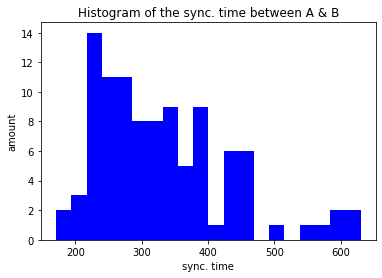

In [9]:
plt.figure()
plt.hist(np.resize(sync_time, (num_sys,)), color = "blue", bins = 20)
plt.title('Histogram of the sync. time between A & B')
plt.xlabel("sync. time")
plt.ylabel("amount")
plt.plot()

We want to see that Eve didn't succeed to converge faster than Alice and Bob:

[]

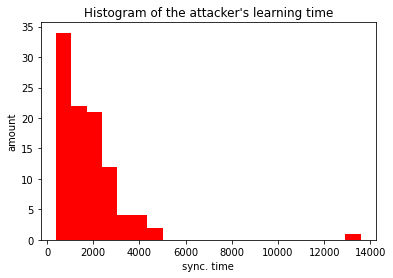

In [10]:
plt.hist(np.resize(attacker_time, (num_sys,)), color = "red",  bins = 20)
plt.title("Histogram of the attacker's learning time")
plt.xlabel("sync. time")
plt.ylabel("amount")
plt.plot(c = 'red')

 The average ratio between the attacker learning time and the synchronization time is 5.699 with std of 4.469
 The minimal ratio  is 1.358


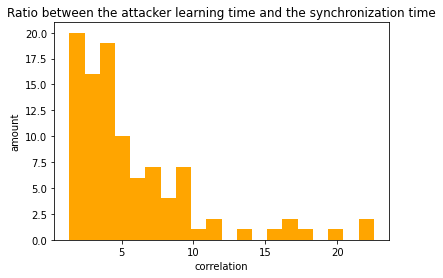

In [11]:
ratio_attack_sync = attacker_time / sync_time

plt.figure()
plt.hist(np.resize(ratio_attack_sync, (num_sys,)), color = "orange", bins = 20)
plt.title('Ratio between the attacker learning time and the synchronization time')
plt.xlabel("correlation")
plt.ylabel("amount")
plt.plot()

print(f" The average ratio between the attacker learning time and the synchronization time is {np.mean(ratio_attack_sync):.3f} with std of {np.std(ratio_attack_sync):.3f}")
print(f" The minimal ratio  is {np.min(ratio_attack_sync):.3f}")

One can say that maybe if we know the initial state of Alice's weights we can evaluate where she will end. We calculate the correlation between Alice's initial and final weights:

 The average correlation between Alice's initial and final weights is -0.002 steps with std of 0.057


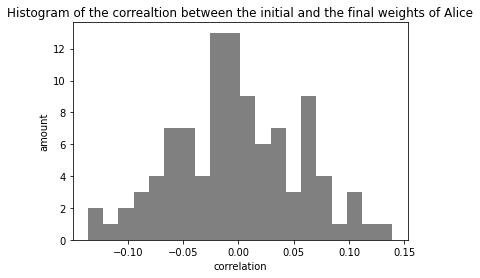

In [12]:
plt.figure()
plt.hist(np.resize(corr_alice, (num_sys,)), color = "grey", bins = 20)
plt.title('Histogram of the correaltion between the initial and the final weights of Alice')
plt.xlabel("correlation")
plt.ylabel("amount")
plt.plot()

print(f" The average correlation between Alice's initial and final weights is {np.mean(corr_alice):.3f} steps with std of {np.std(corr_alice):.3f}")

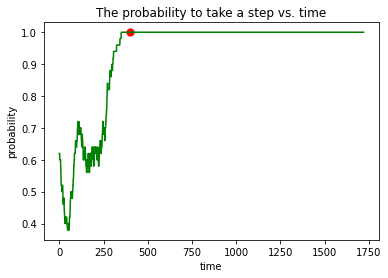

In [13]:
# sliding window
window_size = 50
chance = []
for i in range(len(when_move)-window_size+1):
    chance.append(when_move[range(i, i + window_size)].sum()/window_size)

plt.figure()
plt.title('The probability to take a step vs. time')
plt.xlabel("time")
plt.ylabel("probability")
plt.plot(range(len(chance)), chance, c = 'green')
plt.scatter(int(sync_time[0, -1]), chance[int(sync_time[0, -1])], c = 'red', s = 10, linewidth = 5)

The correlation between Alice and Bob vs Alice and Eve over the learing time

 The average correlation between Alice's initial and final weights is -0.002 steps with std of 0.057


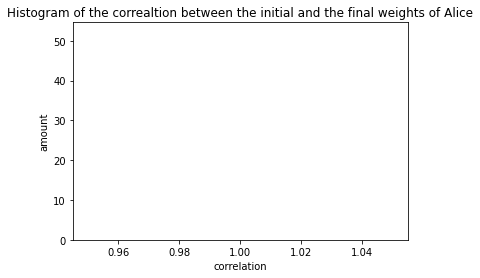

In [14]:
# plt.figure()
# plt.hist(np.resize(corr_alice_bob, (num_sys,)), color = "grey", bins = 20)
# plt.title('Histogram of the correaltion between the initial and the final weights of Alice')
# plt.xlabel("correlation")
# plt.ylabel("amount")
# plt.plot()

# print(f" The average correlation between Alice's initial and final weights is {np.mean(corr_alice):.3f} steps with std of {np.std(corr_alice):.3f}")

In [ ]:
def entropy_calc(arr):
  

### Graphs we want to show:
1. Histogram of the synchronization time between Alice and bob. --- done!
2. The chance of A&B to take a step (sliding window) --- done! (I think...)
3. The correlation between A&B over the learning time (vs. the attacker's correlation)
4. Show how the sync time depends on the constants (N, L, K)- "errorbar"
5. To show that the final weights are not correlated to the initial weights.
6. examine how inputs in [-M, M] affects the information we can get from the final weights.